# Analyze Podcast Transcripts Using BERT

## Introduction

The Power of BERT: NLP Topic Modelling and Analyzing Podcast Transcripts: https://rich-gaogle.medium.com/the-power-of-bert-using-bert-to-analyze-podcast-transcripts-5e30dec738a2

Topic Modelling with BERT: https://towardsdatascience.com/topic-modeling-with-bert-779f7db187e6

Transformer models and BERT model: Overview https://www.youtube.com/watch?v=t45S_MwAcOw

Transformer is an encoder-decoder model that uses the Attention mechanism. (The idea behind the attention mechanism was to permit the decoder to utilize the most relevant parts of the input sequence in a flexible manner, by a weighted combination of all the encoded input vectors, with the most relevant vectors being attributed the highest weights.) Attention mechanism imporves performance of machine translation applications.

Transformer consits of encoder and decoder. Encoder encodes input sequence and passes it to decoder. Decoder decodes the representation for relevant task.

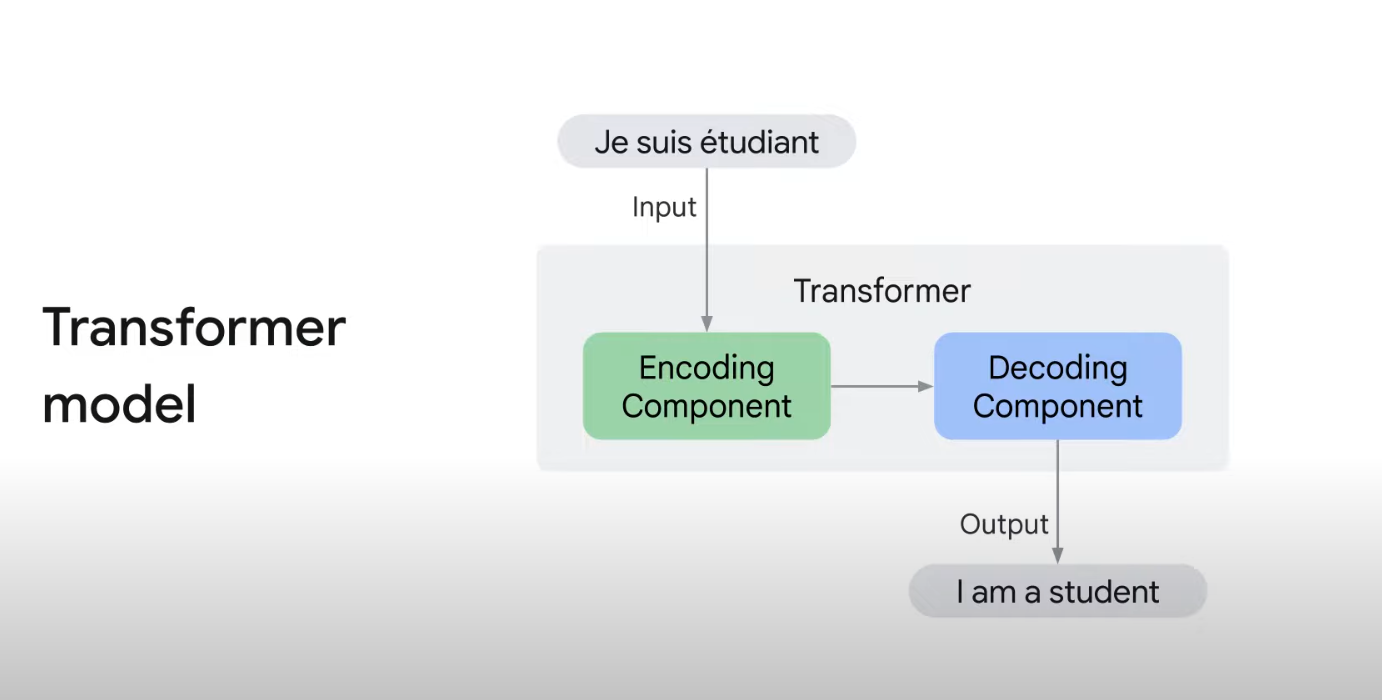

Encoding component is a stack of encoders of the same number (hyperparameter). Each encoder has same structure with different weights.
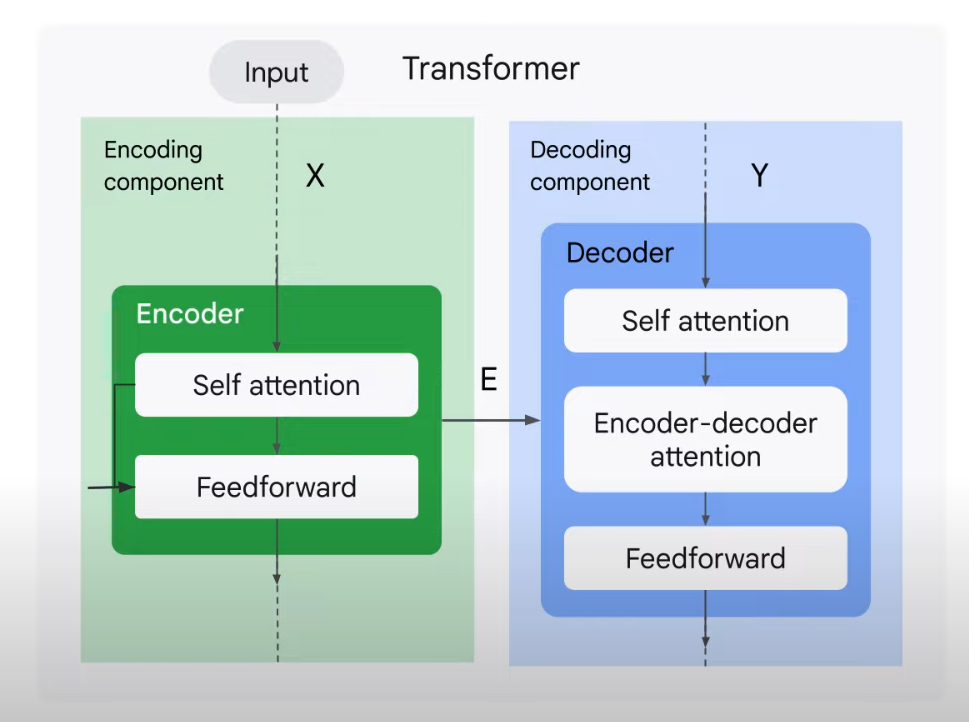

Self attention layer: look at relevant parts of the words as it encodes
Same Feedforward neural network is independetly applied to each position. Feedforward layer allows for parallelization

Encoder-decoder attention layer: helps decoder focus on relevant parts of the input sentence


Within the self attention layer, the input embedding is broken up into query key, and value vectors. These vectors are computed using weights that the transformer learns during the training process. All of the computations happen in parallel in the model in the form of matrix computations. Query, key and value vectors are multipled by the softmax score. The purpose is to keep intact the values of the words we want to focus on and leave out irrelevant words.

Next, we sum up the weighted value vectors which produces the output of the self attention layer to the feedforward neural network. 

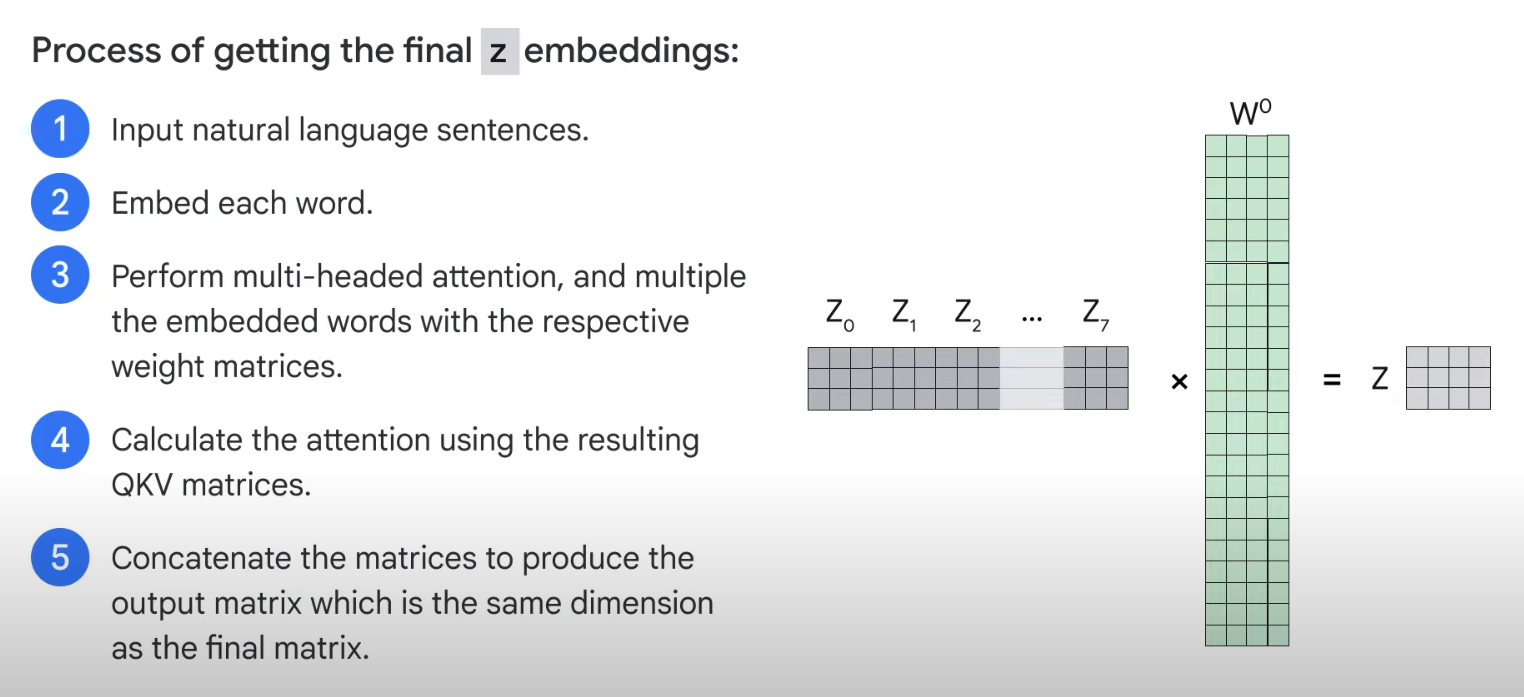

BERT is a trained transformer model (Encoder-only).

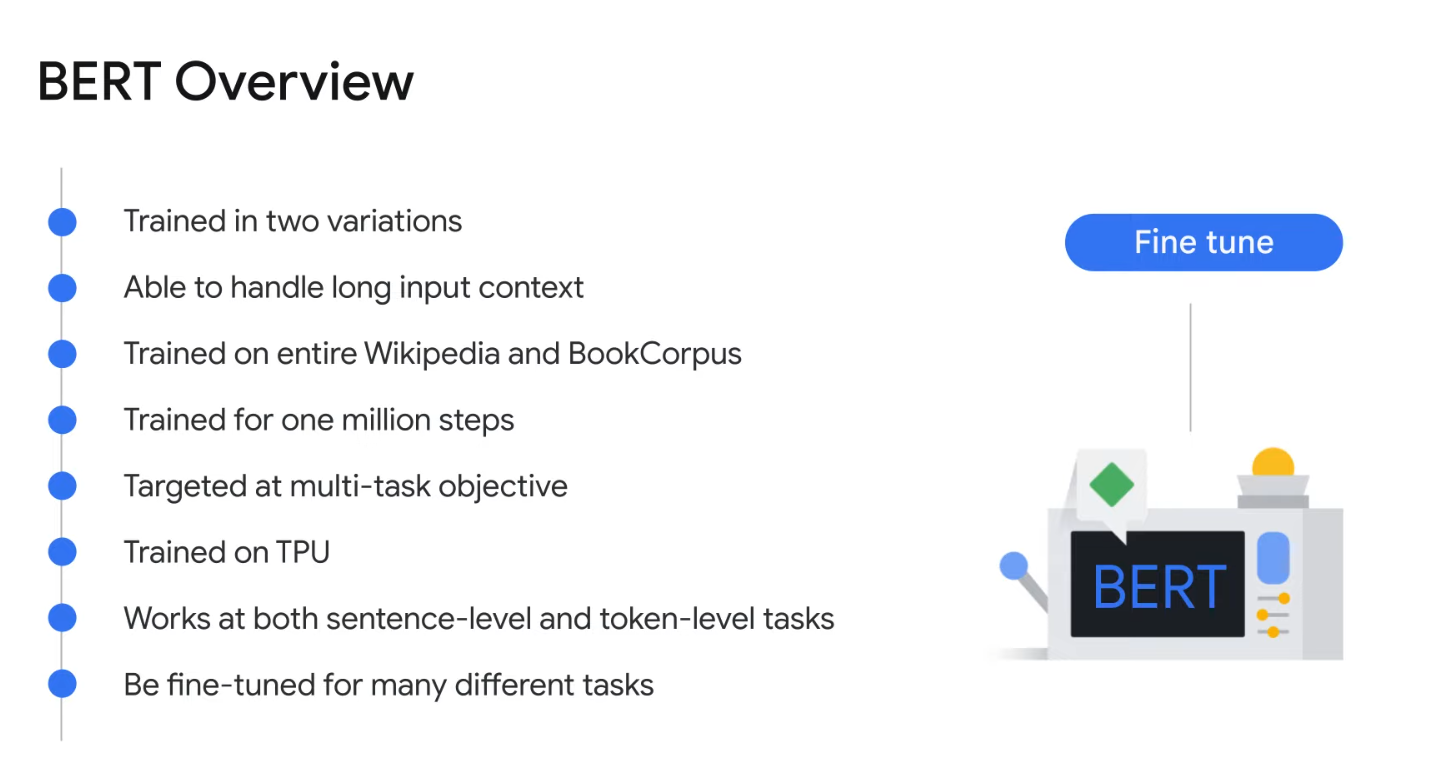

## Web Scraping and Word Cloud

Analysing 'Asking Doctor Mike About Health in Technology' Podcast episode
https://www.youtube.com/watch?v=B_CSzCer1-4

In [1]:
from wordcloud import WordCloud, ImageColorGenerator, STOPWORDS
import matplotlib.pyplot as plt 
from PIL import Image
from os import path, getcwd
import numpy as np
import re
import pandas as pd

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from youtube_transcript_api import YouTubeTranscriptApi
from sklearn.decomposition import PCA

c:\Users\hwhme\anaconda3\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
c:\Users\hwhme\anaconda3\lib\site-packages\numpy\.libs\libopenblas64__v0.3.21-gcc_10_3_0.dll
c:\Users\hwhme\anaconda3\lib\site-packages\numpy\.libs\libopenblas64__v0.3.23-gcc_10_3_0.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [2]:
transcript = []
tx = YouTubeTranscriptApi.get_transcript('B_CSzCer1-4')
for i in tx:
    txt = (i['text'])
    transcript.append(txt)

text = " ".join(transcript)
transcript[:10]

['[Music]',
 'foreign',
 '[Music]',
 'people of the internet welcome back to',
 'another episode of the waveform podcast',
 "we're your hosts I'm Marquez I'm Andrew",
 'and we have a very special guest today',
 'yeah Dr Mike is back I stay back because',
 'uh you helped us out with the Dyson',
 'video we talked about the Dyson Zone']

In [3]:
d = getcwd()

In [4]:
waveform_logo = np.array(Image.open(path.join(d, "waveform_logo.jpg")))

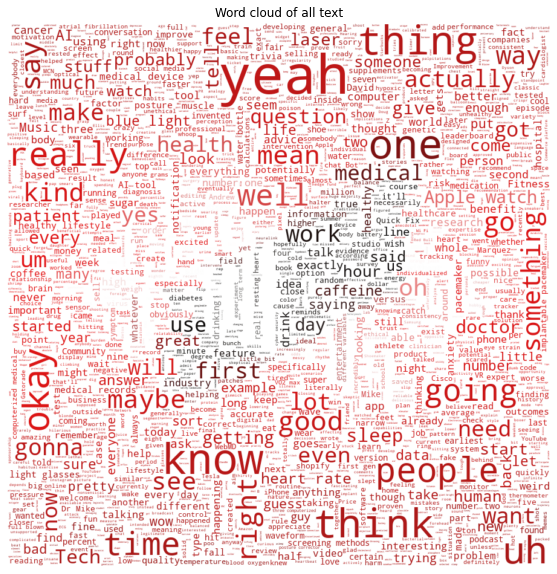

In [5]:
wc= WordCloud(background_color="white", max_words=2000, max_font_size=90, random_state=1, mask=waveform_logo, stopwords=STOPWORDS)
wc.generate(text)

image_colors = ImageColorGenerator(waveform_logo)

plt.figure(figsize=[10,10])
plt.imshow(wc.recolor(color_func=image_colors), interpolation="bilinear")
plt.axis('off')
plt.title('Word cloud of all text')
plt.show()

In [6]:
stop_words = stopwords.words('english')
stop_words.extend(['yeah', 'oh', 'think', 'um', 'uh', '[Music]'])
filtered_transcript = []
for section in transcript:
    words = section.split(" ")
    filtered = []
    for word in words:
        if word not in stop_words:
            filtered.append(word)
    if filtered:
        filtered_transcript.append(" ".join(filtered))

filtered_text = " ".join(filtered_transcript)
filtered_transcript[:10]

['foreign',
 'people internet welcome back',
 'another episode waveform podcast',
 "we're hosts I'm Marquez I'm Andrew",
 'special guest today',
 'Dr Mike back I stay back',
 'helped us Dyson',
 'video talked Dyson Zone',
 "headphones I feel like we've",
 'many conversations studio even']

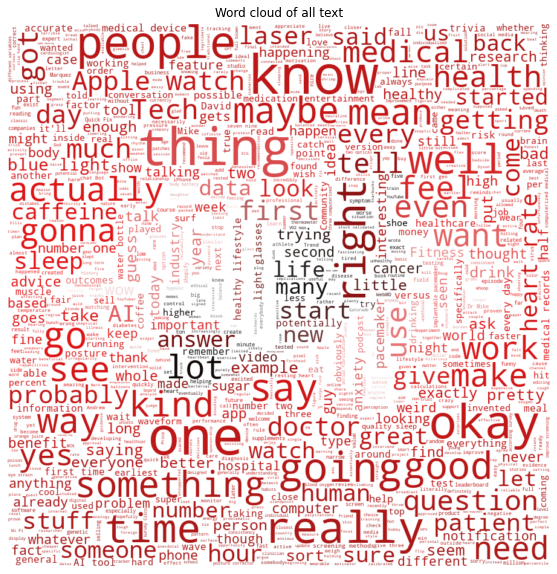

In [7]:
wc= WordCloud(background_color="white", max_words=2000, max_font_size=90, random_state=1, mask=waveform_logo, stopwords=STOPWORDS)
wc.generate(filtered_text)

image_colors = ImageColorGenerator(waveform_logo)

plt.figure(figsize=[10,10])
plt.imshow(wc.recolor(color_func=image_colors), interpolation="bilinear")
plt.axis('off')
plt.title('Word cloud of all text')
plt.show()

## Generate BERT embeddings

In [8]:
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('distilbert-base-nli-mean-tokens')
embeddings = model.encode(filtered_transcript, show_progress_bar=True)

Batches:   0%|          | 0/71 [00:00<?, ?it/s]

Optimal n_components: 56


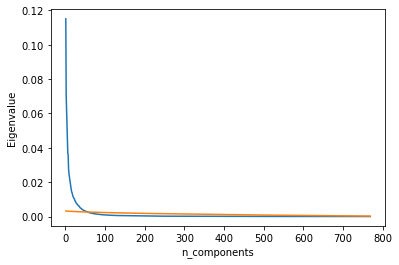

In [9]:
pca = PCA()
pca.fit(embeddings)

variance_ratio = pca.explained_variance_ratio_

X_random = np.random.normal(loc=embeddings.mean(), scale=embeddings.std(), size=embeddings.shape)
# Fit the PCA model to the randomized data
pca_random = PCA()
pca_random.fit(X_random)

eigenvalues_random = pca_random.explained_variance_

component_number = np.arange(1, len(variance_ratio) + 1)

for i in range(len(variance_ratio)):
    r = eigenvalues_random[i] / np.sum(eigenvalues_random)
    if variance_ratio[i] < r:
        print(f"Optimal n_components: {component_number[i-1]}")
        break
    
plt.plot(component_number, variance_ratio, label='Original data')
plt.plot(component_number, eigenvalues_random / np.sum(eigenvalues_random), label='Randomized data')
plt.ylabel('Eigenvalue')
plt.xlabel('n_components')
plt.show()

Optimal n_components: 42


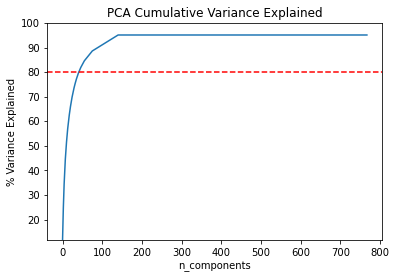

In [10]:
pca = PCA()
pca.fit(embeddings)

variance_ratio = pca.explained_variance_ratio_

cum_var = np.cumsum(np.round(variance_ratio, decimals=3)*100)

component_number = np.arange(1, len(cum_var) + 1)
    
for i in range(len(cum_var)):
    if cum_var[i] > 80:
        print(f"Optimal n_components: {component_number[i-1]}")
        break

plt.plot(cum_var)
plt.ylim(min(cum_var), 100)
plt.axhline(y=80, color='r', linestyle='--')
plt.ylabel('% Variance Explained')
plt.xlabel('n_components')
plt.title('PCA Cumulative Variance Explained')
plt.show()

In [11]:
# Conduct pca to reduce dimensionality for clustering later

pca = PCA(n_components=42)
pca_embeddings = pca.fit_transform(embeddings)
print(pca.explained_variance_ratio_)

[0.11509259 0.0702749  0.06159308 0.05091118 0.04623908 0.03700639
 0.03578309 0.02758873 0.02484766 0.02322984 0.02175527 0.02003264
 0.01861441 0.01632966 0.01526166 0.01419033 0.01370213 0.01260364
 0.01173124 0.01139255 0.01094781 0.01030739 0.01008481 0.0091254
 0.00897287 0.00842153 0.00789605 0.00772294 0.00726507 0.00711902
 0.00672955 0.00641053 0.00634064 0.00615448 0.00585169 0.00545921
 0.00509259 0.0048992  0.00485019 0.00463253 0.00431406 0.00415048]


## Clustering

In [12]:
# Conduct clustering so that documents with similar topics are clustered together

from sklearn.cluster import KMeans

clusters = 15
kmeans = KMeans(n_clusters=clusters)
result = kmeans.fit(pca_embeddings)

C:\Users\hwhme\AppData\Roaming\Python\Python39\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [13]:
docs_df = pd.DataFrame(filtered_transcript, columns=["Doc"])
docs_df['Topic'] = result.labels_
docs_df['Doc_ID'] = range(len(docs_df))
docs_per_topic = docs_df.groupby(['Topic'], as_index = False).agg({'Doc': ' '.join})

## Topic Creation

In [14]:
from sklearn.feature_extraction.text import CountVectorizer

def c_tf_idf(documents, m, ngram_range=(1, 1)):
    count = CountVectorizer(ngram_range=ngram_range, stop_words="english").fit(documents)
    t = count.transform(documents).toarray()
    w = t.sum(axis=1)
    tf = np.divide(t.T, w)
    sum_t = t.sum(axis=0)
    idf = np.log(np.divide(m, sum_t)).reshape(-1, 1)
    tf_idf = np.multiply(tf, idf)

    return tf_idf, count
  
tf_idf, count = c_tf_idf(docs_per_topic.Doc.values, m=len(transcript))

## Topic Representation

In [15]:
def extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=20):
    words = count.get_feature_names_out()
    labels = list(docs_per_topic.Topic)
    tf_idf_transposed = tf_idf.T
    indices = tf_idf_transposed.argsort()[:, -n:]
    top_n_words = {label: [(words[j], tf_idf_transposed[i][j]) for j in indices[i]][::-1] for i, label in enumerate(labels)}
    return top_n_words

def extract_topic_sizes(df):
    topic_sizes = (df.groupby(['Topic'])
                     .Doc
                     .count()
                     .reset_index()
                     .rename({"Topic": "Topic", "Doc": "Size"}, axis='columns')
                     .sort_values("Size", ascending=False))
    return topic_sizes

top_n_words = extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=20)
topic_sizes = extract_topic_sizes(docs_df); topic_sizes.head(10)


,Topic,Size
12,12,247
1,1,232
2,2,221
8,8,218
11,11,151
9,9,149
4,4,143
7,7,142
13,13,137
3,3,132


In [16]:
top_words = []
for topic in list(top_n_words.values()):
    top_words.append([i[0] for i in topic])
top_words[0]

['apple',
 'watch',
 'caffeine',
 'like',
 'sugar',
 'coffee',
 'eat',
 'orange',
 'light',
 'blue',
 'juice',
 'iphone',
 'diabetes',
 'bottle',
 'drinking',
 'drink',
 'glasses',
 'water',
 'started',
 'naive']

In [17]:
import plotly.graph_objects as go

fig = go.Figure(data=[go.Table(header=dict(values=list(top_n_words.keys())),
                 cells=dict(values=top_words))
                     ])

fig.update_layout(width=1200, height=800)
fig.write_image("topics.png") 
fig.show()

![Topic results](topics.png)

BERT has managed to identified relevant topics that were discussed about in the podcast such as energy stimulants in Topic 0 and sleeping habits in topic 5. However, there are some redundant topics such as Topic 1 and 10. This can likely be fixed with more hyperparameter tuning and data preprocessing.

In [18]:
top_n_words[4][:5]

[('know', 0.18270855822021348),
 ('like', 0.09572841715303765),
 ('exactly', 0.09487588622902696),
 ('time', 0.0898033204854593),
 ('real', 0.0754605688891023)]

In [19]:
top_n_words[11][:5]

[('really', 0.12594552353229096),
 ('bad', 0.1164154102300013),
 ('anxiety', 0.09043441847503735),
 ('hard', 0.08145606614330494),
 ('weird', 0.06325145799489836)]